In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from numba import jit, njit
from numba import float64, int64
from numba.experimental import jitclass
from scipy.interpolate import CubicSpline
from quantecon.optimize.root_finding import brentq

In [21]:
@njit
def testfunc(x, alpha, beta, c):
    return alpha * x ** beta - c

params = [
    ('alpha', float64),
    ('beta', float64),
]

@jitclass(params)
class TestClass:
    def __init__(self, 
                 alpha = 1.0, 
                 beta = 1.5):
        self.alpha = alpha
        self.beta = beta
    def testfunc2(self, r):
        c = 2*r
        return brentq(testfunc, 0, 1, args=(self.alpha, self.beta, c))

In [22]:
tc = TestClass()
tc.testfunc2(.25)

results(root=0.6299605249474366, function_calls=8, iterations=7, converged=True)

In [23]:
@njit
def testfunc(x, alpha, beta, c):
    return alpha * x ** beta - c

params = [
    ('alpha', float64),
    ('beta', float64),
]

@jitclass(params)
class TestClass:
    def __init__(self, 
                 alpha = 1.0, 
                 beta = 1.5):
        self.alpha = alpha
        self.beta = beta

@njit
def testfunc2(tc, r):
    c = 2*r
    return brentq(testfunc, 0, 1, args=(tc.alpha, tc.beta, c))

In [24]:
tc = TestClass()
testfunc2(tc, .25)

results(root=0.6299605249474366, function_calls=8, iterations=7, converged=True)

In [29]:
@njit
def testfunc(x, tc, c):
    return tc.testfunc3(x) - c

params = [
    ('alpha', float64),
    ('beta', float64),
]

@jitclass(params)
class TestClass:
    def __init__(self, 
                 alpha = 1.0, 
                 beta = 1.5):
        self.alpha = alpha
        self.beta = beta
    def testfunc3(self, x):
        return self.alpha * x ** self.beta

@njit
def testfunc2(tc, r):
    c = 2*r
    return brentq(testfunc, 0, 1, args=(tc, c))

In [31]:
tc = TestClass()
testfunc2(tc, .25).root

0.6299605249474366

In [33]:
x = np.array([-1, 0, .5, .75, 2, 3])
#bound the elements of x between 0 and 1
np.clip(x, 0, 1)

array([0.  , 0.  , 0.5 , 0.75, 1.  , 1.  ])

In [44]:
import numpy as np
from numba import float64, int32, njit
from numba.experimental import jitclass

spec = [
    ('x', float64[:]),
    ('y', float64[:]),
    ('n', int32),
    ('c', float64[:]),
    ('d', float64[:]),
    ('b', float64[:]),
]

@jitclass(spec)
class Cubic_Spline:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n = len(x)
        self.c = np.zeros(self.n)
        self.d = np.zeros(self.n - 1)
        self.b = np.zeros(self.n - 1)
        
        h = np.diff(self.x)
        alpha = np.zeros(self.n - 1)
        l = np.zeros(self.n)
        mu = np.zeros(self.n - 1)
        z = np.zeros(self.n)

        for i in range(1, self.n - 1):
            alpha[i] = 3 / h[i] * (self.y[i + 1] - self.y[i]) - 3 / h[i - 1] * (self.y[i] - self.y[i - 1])

        l[0] = 1
        mu[0] = 0
        z[0] = 0

        for i in range(1, self.n - 1):
            l[i] = 2 * (self.x[i + 1] - self.x[i - 1]) - h[i - 1] * mu[i - 1]
            mu[i] = h[i] / l[i]
            z[i] = (alpha[i] - h[i - 1] * z[i - 1]) / l[i]

        l[self.n - 1] = 1
        z[self.n - 1] = 0
        self.c[self.n - 1] = 0

        for j in range(self.n - 2, -1, -1):
            self.c[j] = z[j] - mu[j] * self.c[j + 1]
            self.b[j] = (self.y[j + 1] - self.y[j]) / h[j] - h[j] * (self.c[j + 1] + 2 * self.c[j]) / 3
            self.d[j] = (self.c[j + 1] - self.c[j]) / (3 * h[j])

@njit
def cs_eval(cs, x_new):
    y_new = np.zeros_like(x_new)
    for i in range(len(x_new)):
        idx = np.searchsorted(cs.x, x_new[i], side='right') - 1
        idx = np.clip(idx, 0, cs.n - 2)
        h = x_new[i] - cs.x[idx]
        y_new[i] = cs.y[idx] + cs.b[idx] * h + cs.c[idx] * h**2 + cs.d[idx] * h**3
    return y_new

In [45]:
f = lambda x: np.sqrt(x) + 5

x = np.array([0, .5, 1, 2, 5, 10, 15, 20])
y = f(x)

cs = Cubic_Spline(x, y)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function diff at 0x12594bd00>) found for signature:
 
 >>> diff(array(float64, 1d, A))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'np_diff_impl': File: numba/np/arraymath.py: Line 3525.
        With argument(s): '(array(float64, 1d, A))':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       - Resolution failure for literal arguments:
       reshape() supports contiguous array only
       - Resolution failure for non-literal arguments:
       reshape() supports contiguous array only
       
       During: resolving callee type: BoundFunction(array.reshape for array(float64, 1d, A))
       During: typing of call at /opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.10/site-packages/numba/np/arraymath.py (3543)
       
       
       File "../../../../../opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.10/site-packages/numba/np/arraymath.py", line 3543:
           def diff_impl(a, n=1):
               <source elided>
               # To make things easier, normalize input and output into 2d arrays
               a2 = a.reshape((-1, size))
               ^

  raised from /opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.10/site-packages/numba/core/typeinfer.py:1091

During: resolving callee type: Function(<function diff at 0x12594bd00>)
During: typing of call at /var/folders/2m/db9b_l2950xckts1f65_rc2m0000gn/T/ipykernel_40881/3968038901.py (24)


File "../../../../../var/folders/2m/db9b_l2950xckts1f65_rc2m0000gn/T/ipykernel_40881/3968038901.py", line 24:
<source missing, REPL/exec in use?>

During: resolving callee type: jitclass.Cubic_Spline#28d04ceb0<x:array(float64, 1d, A),y:array(float64, 1d, A),n:int32,c:array(float64, 1d, A),d:array(float64, 1d, A),b:array(float64, 1d, A)>
During: typing of call at <string> (3)

During: resolving callee type: jitclass.Cubic_Spline#28d04ceb0<x:array(float64, 1d, A),y:array(float64, 1d, A),n:int32,c:array(float64, 1d, A),d:array(float64, 1d, A),b:array(float64, 1d, A)>
During: typing of call at <string> (3)


File "<string>", line 3:
<source missing, REPL/exec in use?>


---

# Testing EGM

In [5]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [218]:
class OLGModel:
    def __init__(self, 
                 beta=0.97, 
                 gamma=0.40,
                 psi=3.0,
                 sigma=2.0, 
                 alpha=0.36, 
                 delta=0.06,
                 N=66, 
                 J_r=46, 
                 n=0.011,
                 a_min=0.00001, 
                 na=100, 
                 z_grid=np.array([2.0, 0.75]), 
                 initial_dist=np.array([0.2037, 0.7963]),
                 pi=np.array([[0.9261, 0.0739], [0.0189, 0.9811]]),
                 theta=0.11, 
                 eta=np.ones(45)):
        # Primitives
        self.beta = beta                                # discount rate
        self.gamma = gamma                              # Frisch elasticity
        self.psi = psi                                  # disutility of labor
        self.sigma = sigma                              # CRRA consumption
        self.alpha = alpha                              # capital share
        self.delta = delta                              # depreciation rate
        self.N = N                                      # death age
        self.J_r = J_r                                  # age of retirement
        self.n = n                                      # population growth rate
        self.a_min = a_min                              # assets lower bound
        self.na = na                                    # number of asset grid points
        self.z_grid = z_grid                            # productivity shocks
        self.nz = len(z_grid)                           # number of productivity shocks
        self.initial_dist = initial_dist                # initial distribution of productivity
        self.pi = pi                                    # Stochastic process for employment
        self.theta = theta                              # social security tax rate
        self.eta = eta                                  # age-efficiency profile - replace with values 'ef'
        mu = np.ones(N)
        for i in range(1, N):
            mu[i] = mu[i - 1] / (1 + n)
        mu /= np.sum(mu)
        self.mu = mu                                    # age proportions
    def u(self, c):
        return (c**(1-self.sigma)) / (1-self.sigma)
    def v(self, l):
        return self.psi * (l**(1+self.gamma)) / (1+self.gamma)
    def mu_c(self, c):
        return c**(-self.sigma)
    def inv_mu_c(self, value):
        # inverse marginal utility of consumption
        return value ** (-1/self.sigma)
    def l_from_c(self, c, coef):
        # from FOC, coef = w * z * eta * (1 - theta)
        return (coef * c ** (-1/self.sigma) / self.psi) ** (1/self.gamma)

In [219]:
OLG = OLGModel()

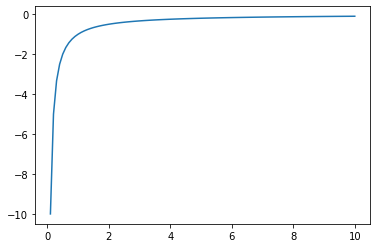

In [220]:
# plot og.u
c = np.linspace(0.1, 10, 100)
plt.plot(c, OLG.u(c))


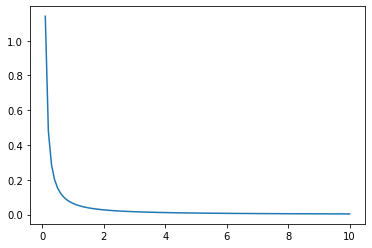

In [221]:
coef = 1
l = OLG.l_from_c(c, coef)
plt.plot(c, l)

In [222]:
def nonuniform_grid(a, b, n=100, density=2):
    '''
    a: lower bound
    b: upper bound
    density: positive scalar for the density of the grid. > 1 for more points at the lower end
    '''
    linear_points = np.linspace(0, 1, n)
    nonlinear_points = (linear_points ** density) * (b-a) + a
    return nonlinear_points 

In [223]:
c_funcs = [None] * OLG.N

a_grids = np.zeros((OLG.J_r - 1, OLG.na))

'''
# find the upper bounds for assets at each working age
a_upper = 0.0
for j in range(OLG.J_r - 1):
    period_income = w * OLG.z_grid[0] * OLG.eta[j] * (1 - OLG.theta)
    a_upper = period_income / 3 + a_upper * (1 + r) # reasonable upper bound
    a_grids[j, :] = nonuniform_grid(OLG.a_min, a_upper, OLG.na)

for j in range(OLG.J_r - 1, OLG.N):
    a_grids[j, :] = nonuniform_grid(OLG.a_min, a_upper, OLG.na)
'''
for j in range(OLG.J_r - 1):
    a_grids[j, :] = nonuniform_grid(OLG.a_min, 35.0, OLG.na)

print(a_grids)

[[1.00000000e-05 3.58106316e-03 1.42942526e-02 ... 3.36001432e+01
  3.42965006e+01 3.50000000e+01]
 [1.00000000e-05 3.58106316e-03 1.42942526e-02 ... 3.36001432e+01
  3.42965006e+01 3.50000000e+01]
 [1.00000000e-05 3.58106316e-03 1.42942526e-02 ... 3.36001432e+01
  3.42965006e+01 3.50000000e+01]
 ...
 [1.00000000e-05 3.58106316e-03 1.42942526e-02 ... 3.36001432e+01
  3.42965006e+01 3.50000000e+01]
 [1.00000000e-05 3.58106316e-03 1.42942526e-02 ... 3.36001432e+01
  3.42965006e+01 3.50000000e+01]
 [1.00000000e-05 3.58106316e-03 1.42942526e-02 ... 3.36001432e+01
  3.42965006e+01 3.50000000e+01]]


In [224]:
r, w, b = .05, 1.05, .2

In [225]:
c_r = a_grids[-1, :] * (1 + r) + b           # retired consumption policy
c_funcs[-1] = CubicSpline(a_grids[-1, :], c_r) 

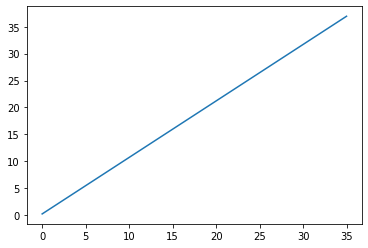

In [226]:
# plot the consumption policy function
a = np.linspace(0, 35, 100)
plt.plot(a, c_funcs[-1](a))

In [227]:
for j in range(OLG.N - 1, OLG.J_r - 2, -1):
    c_next = c_funcs[j](a_grids[-1, :])
    c_r = OLG.inv_mu_c(OLG.beta * (1+r) * OLG.mu_c(c_next))
    # find asset holdings from BC
    new_grid = (a_grids[-1, :] + c_r - b) / (1 + r)
    c_funcs[j - 1] = CubicSpline(new_grid, c_r)

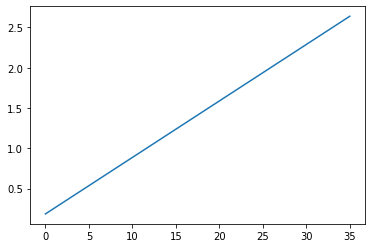

In [228]:
# plot the consumption policy function at age 45
plt.plot(a, c_funcs[44](a))

In [229]:
# start just before retirement
c_funcs[OLG.J_r - 2] = []
# find c with Euler equation, find l with FOC
for z_index, z in enumerate(OLG.z_grid):
    coef = w * z * OLG.eta[-1] * (1 - OLG.theta)
    c_next = c_funcs[OLG.J_r - 1](a_grids[-1, :])
    c_w = OLG.inv_mu_c(OLG.beta * (1 + r) * OLG.mu_c(c_next))
    l_w = OLG.l_from_c(c_w, coef)
    l_w = np.clip(l_w, 0, 1) # enforce bounds
    # find asset holdings from BC
    new_grid = (a_grids[-1, :] + c_w - coef * l_w) / (1 + r)
    # get rid of the values where new_grid is negative
    negative_indices = np.where(new_grid < 0)
    new_grid = np.delete(new_grid, negative_indices)
    c_w = np.delete(c_w, negative_indices)
    c_funcs[OLG.J_r - 2].append(CubicSpline(new_grid, c_w))

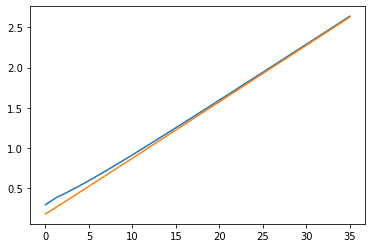

In [230]:
# plot the age 44 consumption policy function for each z
for i in range(len(OLG.z_grid)):
    plt.plot(a_grids[-1, :], c_funcs[OLG.J_r - 2][i](a_grids[-1, :]))

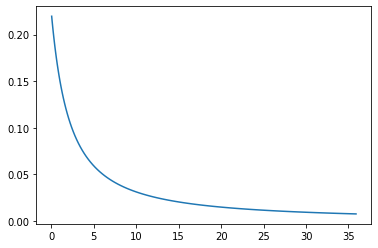

In [231]:
# plot l_w against new_grid
plt.plot(new_grid, l_w)

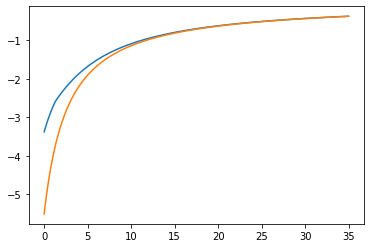

In [232]:
# plot the period consumption utility function at age 44 for each z
for i in range(len(OLG.z_grid)):
    plt.plot(a_grids[-1, :], OLG.u(c_funcs[OLG.J_r - 2][i](a_grids[-1, :])))


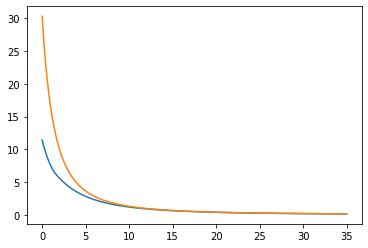

In [233]:
# plot the marginal utility of consumption at age 44 for each z
for i in range(len(OLG.z_grid)):
    plt.plot(a_grids[-1, :], OLG.mu_c(c_funcs[OLG.J_r - 2][i](a_grids[-1, :])))

In [234]:
for j in range(OLG.J_r - 2, 0, -1):
    c_funcs[j - 1] = []    
    for z_index, z in enumerate(OLG.z_grid):
        coef = w * z * OLG.eta[j-1] * (1 - OLG.theta)
        # find the expected marginal utility of consumption in the next period
        E_mu_c = np.zeros(OLG.na)
        for zp_index in range(OLG.nz):
            mu_c_zp = OLG.mu_c(c_funcs[j][zp_index](a_grids[j, :]))
            E_mu_c += OLG.pi[z_index, zp_index] * mu_c_zp
        c_w = OLG.inv_mu_c(OLG.beta * (1 + r) * E_mu_c)
        l_w = OLG.l_from_c(c_w, coef)
        l_w = np.clip(l_w, 0, 1) # enforce bounds
        new_grid = (a_grids[j, :] + c_w - coef * l_w) / (1 + r)
        negative_indices = np.where(new_grid < 0)
        new_grid = np.delete(new_grid, negative_indices)
        c_w = np.delete(c_w, negative_indices)
        l_w = np.delete(l_w, negative_indices)
        c_funcs[j - 1].append(CubicSpline(new_grid, c_w))

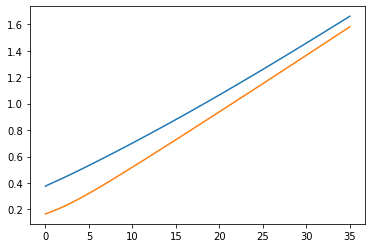

In [235]:
# plot the age 43 consumption policy function for each z
plt.plot(a_grids[0, :], c_funcs[0][0](a_grids[0, :]))
plt.plot(a_grids[0, :], c_funcs[0][1](a_grids[0, :]))

In [240]:
# get policy functions on grid using c_funcs
a_policy_w = np.empty((OLG.J_r-1, OLG.nz, OLG.na)) # savings policy function for workers
a_policy_r = np.empty((OLG.N-OLG.J_r, OLG.na))         # savings policy function for retirees
c_policy_w = np.empty((OLG.J_r-1, OLG.nz, OLG.na)) # consumption policy function for workers
c_policy_r = np.empty((OLG.N-OLG.J_r, OLG.na))         # consumption policy function for retirees
l_policy = np.empty((OLG.J_r-1, OLG.nz, OLG.na))   # labor policy function for workers

for j in range(OLG.J_r - 1):
    for z_index, z in enumerate(OLG.z_grid):
        coef = w * z * OLG.eta[j] * (1 - OLG.theta)
        c_policy_w[j, z_index, :] = c_funcs[j][z_index](a_grids[j, :])
        l_policy[j, z_index, :] = np.clip(OLG.l_from_c(c_policy_w[j, z_index, :], coef), 0, 1)
        a_policy_w[j, z_index, :] = (1+r) * a_grids[j, :] + coef*l_policy[j, z_index, :] - c_policy_w[j, z_index, :]

for j in range(OLG.N - OLG.J_r):
    c_policy_r[j, :] = c_funcs[j + OLG.J_r](a_grids[-1, :])
    a_policy_r[j, :] = (1+r) * a_grids[-1, :] + b - c_policy_r[j, :]

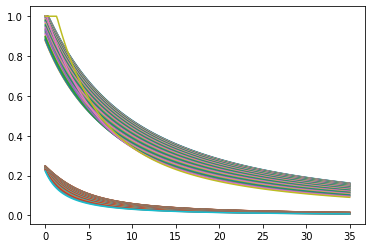

In [237]:
for j in range(OLG.J_r - 1):
    for z_index, z in enumerate(OLG.z_grid):
        plt.plot(a_grids[j, :], l_policy[j, z_index, :])

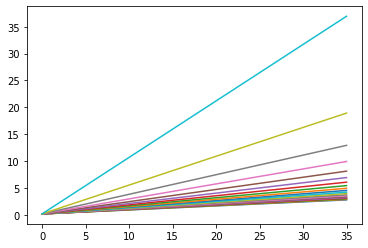

In [241]:
for j in range(OLG.N - OLG.J_r):
    plt.plot(a_grids[-1, :], c_policy_r[j, :])

## What's wrong with the labor supply?

In [68]:
import numpy as np
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [85]:
w = .1
r = 0.05
gamma = 2.5
sigma = 2.0
beta = .97
a_grid = np.linspace(0.0001, 35, 250)

In [86]:
# grid search first

def find_l(l, w, a, ap, gamma, sigma):
    return w * l + (1+r)*a - ap - (l ** gamma / w) ** (-1 / sigma)

u = lambda c: c ** (1 - sigma) / (1 - sigma)
v = lambda l: l ** (1 + gamma) / (1 + gamma)


a_opt = np.zeros_like(a_grid)
c_opt = np.zeros_like(a_grid)
l_opt = np.zeros_like(a_grid)

for a_index, a in enumerate(a_grid):
    candidate = - np.inf

    for ap_index, ap in enumerate(a_grid):
        l = brentq(find_l, 0.000001, 100, args=(w, a, ap, gamma, sigma))
        l = np.clip(l, 0, 1)
        c = w * l + (1+r)*a - ap
        if c < 0:
            break
        val = u(c) + v(l) + beta * u((1+r)*ap)
        if val > candidate:
            candidate = val
            a_opt[a_index] = ap
            c_opt[a_index] = c
            l_opt[a_index] = l

Text(0.5, 0, 'Assets')

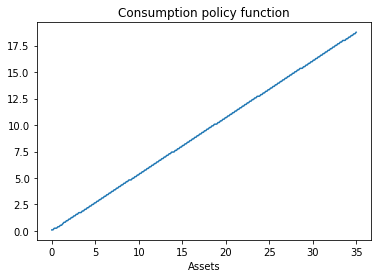

In [91]:
# plot the consumption policy function
plt.plot(a_grid, c_opt)
plt.title('Consumption policy function')
plt.xlabel('Assets')

Text(0.5, 0, 'Assets')

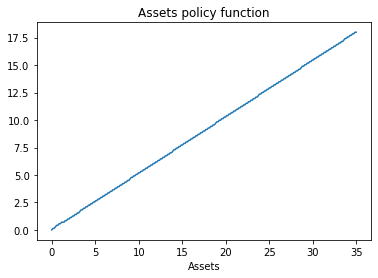

In [92]:
# plot the assets policy function
plt.plot(a_grid, a_opt)
plt.title('Assets policy function')
plt.xlabel('Assets')

Text(0.5, 0, 'Assets')

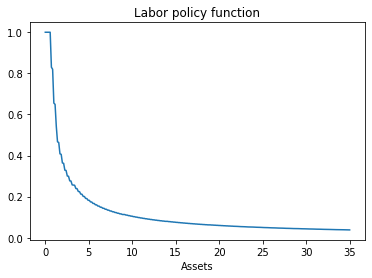

In [93]:
# plot the labor policy function
plt.plot(a_grid, l_opt)
plt.title('Labor policy function')
plt.xlabel('Assets')

In [94]:
# now, EGM

c2_policy = lambda a: (1+r) * a

c1 = (beta * (1+r)) ** (-1/sigma) * c2_policy(a_grid)
l1 = (w / (c1 ** sigma)) ** (1/gamma)
l1 = np.clip(l1, 0, 1)
a1 = (c1 + a_grid - w*l1) / (1+r)

bad_indices = np.where(a1 < 0)
a1 = np.delete(a1, bad_indices)
c1 = np.delete(c1, bad_indices)
l1 = np.delete(l1, bad_indices)

c1_policy = CubicSpline(a1, c1)

c_opt_egm = c1_policy(a_grid)
l_opt_egm = (w / (c_opt_egm ** sigma)) ** (1/gamma)
l_opt_egm = np.clip(l_opt_egm, 0, 1)
a_opt_egm = (1+r) * a_grid + w*l_opt_egm - c_opt_egm


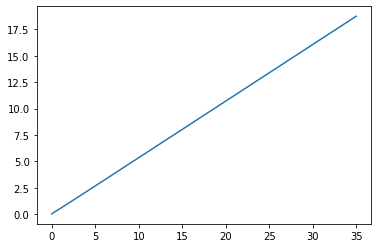

In [95]:
# plot the consumption policy function
plt.plot(a_grid, c_opt_egm)

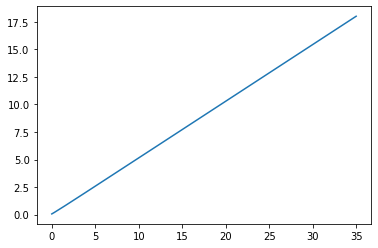

In [96]:
# plot the assets policy function
plt.plot(a_grid, a_opt_egm)

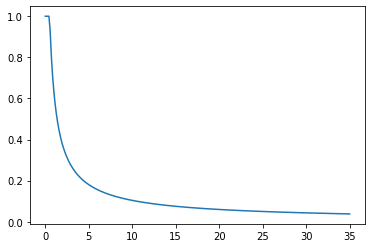

In [97]:
plt.plot(a_grid, l_opt_egm)

In [12]:
import numpy as np

x = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
f = lambda x: x ** 2
y = f(x)

y_vals = np.linspace(0, 1, 51)

# discretize y onto y_vals
y_indices = np.digitize(y, y_vals) - 1
y_discretized = y_vals[y_indices]

In [13]:
y

array([0.01, 0.04, 0.09, 0.16, 0.25, 0.36, 0.49, 0.64, 0.81, 1.  ])

In [14]:
y_discretized

array([0.  , 0.04, 0.08, 0.16, 0.24, 0.36, 0.48, 0.64, 0.8 , 1.  ])

---


In [64]:
import numpy as np
from scipy.interpolate import CubicSpline
from numba import njit, float64, int64
from numba.experimental import jitclass

@njit
def nonuniform_grid(a, b, n=100, density=2):
    '''
    a: lower bound
    b: upper bound
    density: positive scalar for the density of the grid. > 1 for more points at the lower end
    '''
    linear_points = np.linspace(0, 1, n)
    nonlinear_points = (linear_points ** density) * (b-a) + a
    return nonlinear_points 


primitives = [
    ('beta', float64),
    ('gamma', float64),
    ('psi', float64),
    ('sigma', float64),
    ('alpha', float64),
    ('delta', float64),
    ('N', int64),
    ('J_r', int64),
    ('n', float64),
    ('a_min', float64),
    ('a_max', float64),
    ('na', int64),
    ('a_grid', float64[:]),
    ('z_grid', float64[:]),
    ('nz', int64),
    ('initial_dist', float64[:]),
    ('pi', float64[:,:]),
    ('theta', float64),
    ('eta', float64[:]),
    ('mu', float64[:])
]

@jitclass(primitives)
class OLGModel:
    def __init__(self, 
                 beta=0.97, 
                 gamma=2.50,
                 psi=2.0,
                 sigma=2.0, 
                 alpha=0.36, 
                 delta=0.06,
                 N=66, 
                 J_r=46, 
                 n=0.011,
                 a_min=0.00001,
                 a_max=35.0, 
                 na=1000, 
                 z_grid=np.array([2.0, 0.3]), 
                 initial_dist=np.array([0.2037, 0.7963]),
                 pi=np.array([[0.9261, 0.0739], [0.0189, 0.9811]]),
                 theta=0.11, 
                 eta=np.ones(45)):
        # Primitives
        self.beta = beta                                # discount rate
        self.gamma = gamma                              # Frisch elasticity
        self.psi = psi                                  # disutility of labor
        self.sigma = sigma                              # CRRA consumption
        self.alpha = alpha                              # capital share
        self.delta = delta                              # depreciation rate
        self.N = N                                      # death age
        self.J_r = J_r                                  # age of retirement
        self.n = n                                      # population growth rate
        self.a_min = a_min                              # assets lower bound
        self.a_max = a_max                              # assets upper bound
        self.na = na                                    # number of asset grid points
        self.a_grid = nonuniform_grid(a_min, a_max, na)
        self.z_grid = z_grid                            # productivity shocks
        self.nz = len(z_grid)                           # number of productivity shocks
        self.initial_dist = initial_dist                # initial distribution of productivity
        self.pi = pi                                    # Stochastic process for employment
        self.theta = theta                              # social security tax rate
        self.eta = eta                                  # age-efficiency profile - replace with values 'ef'
        mu = np.ones(N)
        for i in range(1, N):
            mu[i] = mu[i - 1] / (1 + n)
        mu /= np.sum(mu)
        self.mu = mu                                    # age proportions
    def u(self, c):
        return (c**(1-self.sigma)) / (1-self.sigma)
    def v(self, l):
        return self.psi * (l**(1+self.gamma)) / (1+self.gamma)
    def mu_c(self, c):
        return c**(-self.sigma)
    def inv_mu_c(self, value):
        # inverse marginal utility of consumption
        return value ** (-1/self.sigma)
    def l_from_c(self, c, coef):
        # from FOC, coef = w * z * eta * (1 - theta)
        return (coef * c ** (-self.sigma) / self.psi) ** (1/self.gamma)

def HH_egm(OLG, r=.05, w=1.05, b=.2):
    # solve household problem using endogenous grid method
    c_funcs = [None] * OLG.N
    a_grid = OLG.a_grid

    # start at the end of life               
    c_r = a_grid * (1 + r) + b           # retired consumption policy
    c_funcs[-1] = CubicSpline(a_grid, c_r) 
    
    # iterate backward with Euler equation
    for j in range(OLG.N - 2, OLG.J_r - 2, -1):
        c_next = c_funcs[j+1](a_grid)
        c_r = OLG.inv_mu_c(OLG.beta * (1+r) * OLG.mu_c(c_next))
        # find asset holdings from BC
        new_grid = (a_grid + c_r - b) / (1 + r)
        c_funcs[j] = CubicSpline(new_grid, c_r)

    # start just before retirement
    c_funcs[OLG.J_r - 2] = []
    # find c with Euler equation, find l with FOC
    for z_index, z in enumerate(OLG.z_grid):
        coef = w * z * OLG.eta[-1] * (1 - OLG.theta)
        c_next = c_funcs[OLG.J_r - 1](a_grid)
        c_w = OLG.inv_mu_c(OLG.beta * (1 + r) * OLG.mu_c(c_next))
        l_w = OLG.l_from_c(c_w, coef)
        l_w = np.clip(l_w, 0, 1) # enforce bounds
        # find asset holdings from BC
        new_grid = (a_grid + c_w - coef * l_w) / (1 + r)
        if np.diff(new_grid).min() < 0:
            print("new_grid:")
            print(new_grid)
            print(c_w)
            # find the index where np.diff(new_grid) < 0
            print(np.where(np.diff(new_grid) < 0))
        c_funcs[OLG.J_r - 2].append(CubicSpline(new_grid, c_w))

    # iterate backwards with Euler equation for workers
    for j in range(OLG.J_r - 3, -1, -1):
        c_funcs[j] = []
        for z_index, z in enumerate(OLG.z_grid):
            coef = w * z * OLG.eta[j] * (1 - OLG.theta)
            # find the expected marginal utility of consumption in the next period
            E_mu_c = np.zeros(OLG.na)
            for zp_index in range(OLG.nz):
                mu_c_zp = OLG.mu_c(c_funcs[j+1][zp_index](a_grid))
                E_mu_c += OLG.pi[z_index, zp_index] * mu_c_zp
            c_w = OLG.inv_mu_c(OLG.beta * (1 + r) * E_mu_c)
            l_w = OLG.l_from_c(c_w, coef)
            l_w = np.clip(l_w, 0, 1) # enforce bounds
            new_grid = (a_grid + c_w - coef * l_w) / (1 + r)
            if np.diff(new_grid).min() < 0:
                print("new_grid:")
                print(new_grid)
                print(c_w)
                print(l_w)
                # find the index where np.diff(new_grid) < 0
                print(np.where(np.diff(new_grid) < 0))
            c_funcs[j].append(CubicSpline(new_grid, c_w))
    
    # get policy functions on grid using c_funcs
    a_policy_w = np.empty((OLG.J_r-1, OLG.nz, OLG.na)) # savings policy function for workers
    a_policy_r = np.empty((OLG.N-OLG.J_r + 1, OLG.na))         # savings policy function for retirees
    c_policy_w = np.empty((OLG.J_r-1, OLG.nz, OLG.na)) # consumption policy function for workers
    c_policy_r = np.empty((OLG.N-OLG.J_r + 1, OLG.na))         # consumption policy function for retirees
    l_policy = np.empty((OLG.J_r-1, OLG.nz, OLG.na))   # labor policy function for workers

    for j in range(OLG.J_r - 1):
        for z_index, z in enumerate(OLG.z_grid):
            coef = w * z * OLG.eta[j] * (1 - OLG.theta)
            c_policy_w[j, z_index, :] = c_funcs[j][z_index](a_grid)
            l_policy[j, z_index, :] = np.clip(OLG.l_from_c(c_policy_w[j, z_index, :], coef), 0, 1)
            a_policy_w[j, z_index, :] = (1+r) * a_grid + coef*l_policy[j, z_index, :] - c_policy_w[j, z_index, :]

    for j in range(OLG.N - OLG.J_r + 1):
        c_policy_r[j, :] = c_funcs[j + OLG.J_r - 1](a_grid)
        a_policy_r[j, :] = (1+r) * a_grid + b - c_policy_r[j, :]

    return a_policy_w, a_policy_r, c_policy_w, c_policy_r, l_policy, c_funcs



In [65]:
@njit
def steady_dist_egm(OLG, a_policy_w, a_policy_r):
    # Initialize distributions
    h_r = np.zeros((OLG.N - OLG.J_r + 1, OLG.na))
    h_w = np.zeros((OLG.J_r - 1, OLG.na, OLG.nz))

    # Initial distribution for workers
    h_w[0, 0, :] = OLG.initial_dist * OLG.mu[0]

    # Iterate forward for workers
    for j in range(1, OLG.J_r - 1):
        for a_k in range(OLG.na):
            for z in range(OLG.nz):
                for z_next in range(OLG.nz):
                    a_next = a_policy_w[j-1, z, a_k]
                    
                    # Find the position of a_next in the grid
                    if a_next <= OLG.a_grid[0]:
                        h_w[j, 0, z_next] += h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)
                    elif a_next >= OLG.a_grid[-1]:
                        h_w[j, -1, z_next] += h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)
                    else:
                        # Find the two nearest grid points
                        idx = np.searchsorted(OLG.a_grid, a_next)
                        # Split the probability between the two nearest grid points
                        weight_high = (a_next - OLG.a_grid[idx-1]) / (OLG.a_grid[idx] - OLG.a_grid[idx-1])
                        weight_low = 1 - weight_high
                        h_w[j, idx-1, z_next] += weight_low * h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)
                        h_w[j, idx, z_next] += weight_high * h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)

    # Transition from workers to retirees
    for a_k in range(OLG.na):
        for z in range(OLG.nz):
            a_next = a_policy_w[OLG.J_r-2, z, a_k]
            
            if a_next <= OLG.a_grid[0]:
                h_r[0, 0] += h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)
            elif a_next >= OLG.a_grid[-1]:
                h_r[0, -1] += h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)
            else:
                idx = np.searchsorted(OLG.a_grid, a_next)
                weight_high = (a_next - OLG.a_grid[idx-1]) / (OLG.a_grid[idx] - OLG.a_grid[idx-1])
                weight_low = 1 - weight_high
                h_r[0, idx-1] += weight_low * h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)
                h_r[0, idx] += weight_high * h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)

    # Iterate forward for retirees
    for j in range(1, OLG.N - OLG.J_r + 1):
        for a_k in range(OLG.na):
            a_next = a_policy_r[j-1, a_k]
            
            if a_next <= OLG.a_grid[0]:
                h_r[j, 0] += h_r[j-1, a_k] / (1 + OLG.n)
            elif a_next >= OLG.a_grid[-1]:
                h_r[j, -1] += h_r[j-1, a_k] / (1 + OLG.n)
            else:
                idx = np.searchsorted(OLG.a_grid, a_next)
                weight_high = (a_next - OLG.a_grid[idx-1]) / (OLG.a_grid[idx] - OLG.a_grid[idx-1])
                weight_low = 1 - weight_high
                h_r[j, idx-1] += weight_low * h_r[j-1, a_k] / (1 + OLG.n)
                h_r[j, idx] += weight_high * h_r[j-1, a_k] / (1 + OLG.n)

    # Normalize the distributions
    total_mass = np.sum(h_w) + np.sum(h_r)
    h_w /= total_mass
    h_r /= total_mass

    return h_w, h_r

@njit
def markov_simulation(pi, initial_dist, T):
    """
    Simulate a Markov process.
    
    Parameters:
    - pi: transition matrix
    - initial_dist: initial distribution
    - T: number of periods to simulate
    
    Returns:
    - states: array of simulated states
    """
    states = np.zeros(T, dtype=np.int64)
    states[0] = np.searchsorted((np.cumsum(initial_dist) > np.random.rand()).astype(np.int64), 1)
    
    for t in range(1, T):
        states[t] = np.searchsorted((np.cumsum(pi[states[t-1]]) > np.random.rand()).astype(np.int64), 1)
    
    return states

@njit
def stochastic_simulation(OLG, a_policy_w, a_policy_r, M=10000):
    """
    Stochastic simulation method for estimating the distribution of agents.
    
    Parameters:
    - OLG: instance of OLGModel class
    - a_policy_w: asset policy function for workers (shape: [J_r-1, nz, na])
    - a_policy_r: asset policy function for retirees (shape: [N-J_r+1, na])
    - M: number of households to simulate (default: 10000)
    
    Returns:
    - h_w: distribution of working households (shape: [J_r-1, na, nz])
    - h_r: distribution of retired households (shape: [N-J_r+1, na])
    """
    
    # Initialize arrays to store asset holdings and productivity for each household
    asset_holdings = np.zeros((M, OLG.N))
    productivity = np.zeros((M, OLG.J_r - 1), dtype=np.int64)
    
    # Simulate productivity shocks for working years
    for m in range(M):
        productivity[m] = markov_simulation(OLG.pi, OLG.initial_dist, OLG.J_r - 1)
    
    # Simulate asset accumulation
    for m in range(M):
        for j in range(1, OLG.J_r):
            z = productivity[m, j-1]
            a = asset_holdings[m, j-1]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            asset_holdings[m, j] = a_policy_w[j-1, z, a_index]
        
        for j in range(OLG.J_r, OLG.N + 1):
            a = asset_holdings[m, j-1]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            asset_holdings[m, j] = a_policy_r[j-OLG.J_r, a_index]
    
    # Initialize distribution arrays
    h_w = np.zeros((OLG.J_r - 1, OLG.na, OLG.nz))
    h_r = np.zeros((OLG.N - OLG.J_r + 1, OLG.na))
    
    # Bin the data and weight by age group
    for j in range(OLG.J_r - 1):
        for m in range(M):
            z = productivity[m, j]
            a = asset_holdings[m, j]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            h_w[j, a_index, z] += OLG.mu[j]
    
    for j in range(OLG.J_r, OLG.N + 1):
        for m in range(M):
            a = asset_holdings[m, j]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            h_r[j-OLG.J_r, a_index] += OLG.mu[j]
    
    # Normalize distributions
    h_w /= M
    h_r /= M
    
    return h_w, h_r

@njit
def K_L(OLG, h_w, h_r, l_w):
    # compute capital and labor supply implied by household decisions
    K = 0.0
    L = 0.0
    for j in range(OLG.J_r - 1):  # workers
        for a_index, a in enumerate(OLG.a_grid):
            for z_index, z in enumerate(OLG.z_grid):
                K += h_w[j, a_index, z_index] * a
                L += h_w[j, a_index, z_index] * z * OLG.eta[j] * l_w[j, z_index, a_index]

    for j in range(OLG.N - OLG.J_r + 1):
        for a_index, a in enumerate(OLG.a_grid):
            K += h_r[j, a_index] * a

    return K, L

def market_clearing(OLG, tol=0.0001, max_iter=200, rho=.02, K0=3.32, L0=0.34):
    # solve for the steady state using initial guess of capital and labor

    K, L = K0, L0
    n = 0
    # need initial retired share, will actually be very close to this value
    mu_r = np.sum(OLG.mu[OLG.J_r - 1:])
    error = 100 * tol
    while error > tol:
        r = OLG.alpha * (L / K) ** (1 - OLG.alpha) - OLG.delta
        w = (1 - OLG.alpha) * (K / L) ** OLG.alpha
        b = OLG.theta * w * L / mu_r
        a_w, a_r, _, _, l_w, _ = HH_egm(OLG, r, w, b)
        h_w, h_r = steady_dist_egm(OLG, a_w, a_r)
        K_new, L_new = K_L(OLG, h_w, h_r, l_w)
        K = (1-rho) * K + rho * K_new
        L = (1-rho) * L + rho * L_new
        print(f"K = {K}, L = {L}")
        error = max(abs(K_new - K), abs(L_new - L))
        n += 1
        if n > max_iter:
            print("No convergence")
            print(f"K = {K}, L = {L}")
            break

    if n < max_iter:
        print(f"Converged in {n} iterations")
        return K, L, r, w, b

Text(0.5, 1.0, 'Age-efficiency profile')

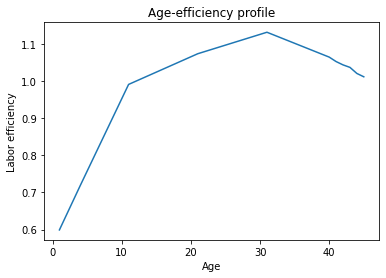

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import time

# read in ef.txt as a numpy array
ef = np.loadtxt('ef.txt', delimiter=',')

# plot ef across [1, .., len(ef)]
x = np.arange(1, len(ef)+1)
plt.plot(x, ef)
plt.xlabel('Age')
plt.ylabel('Labor efficiency')
plt.title('Age-efficiency profile')

In [67]:
# time the HH_egm function
og = OLGModel(eta=ef, na=500, gamma=2.5, a_min=.000001, a_max=25.0, z_grid=np.array([1.0, .25]))

start = time.time()
a_policy_w, a_policy_r, c_policy_w, c_policy_r, l_policy, c_funcs = HH_egm(og, r=.032, w=1.38, b=.181)
end = time.time()
print(f'Time elapsed: {end-start}')

Time elapsed: 0.2844829559326172


In [68]:
# time the HH_egm function
og = OLGModel(na=500, gamma=2.5, a_min=.000001, a_max=25.0, z_grid=np.array([1.0, .25]))


a_policy_w, a_policy_r, c_policy_w, c_policy_r, l_policy, c_funcs = HH_egm(og, r=.032, w=1.38, b=.181)

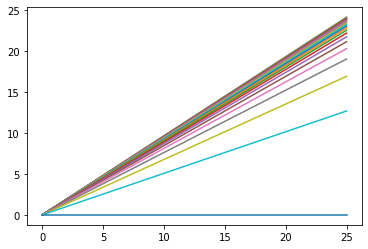

In [69]:
# plot a_policy_r for each j
for j in range(og.N - og.J_r + 1):
    plt.plot(og.a_grid, a_policy_r[j, :])

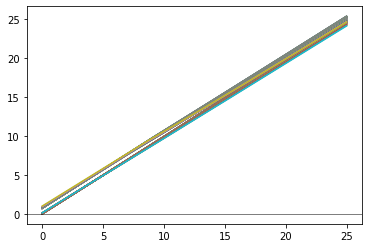

In [70]:
for j in range(og.J_r - 1):
    for z_index, z in enumerate(og.z_grid):
        plt.plot(og.a_grid, a_policy_w[j, z_index, :])

# add a horizontal line at y=0
plt.axhline(0, color='black', lw=0.5)

In [71]:
j = -1

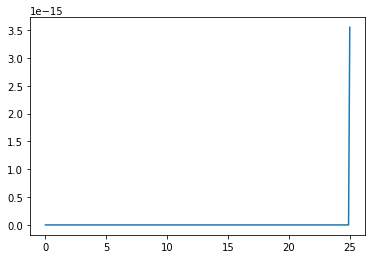

In [72]:
plt.plot(og.a_grid, a_policy_r[j, :])

In [73]:
j = 0

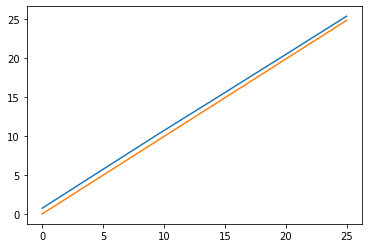

In [74]:
plt.plot(og.a_grid, a_policy_w[j, 0, :])
plt.plot(og.a_grid, a_policy_w[j, 1, :])

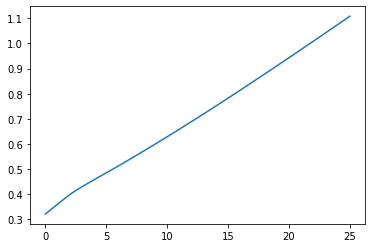

In [75]:
# plot c_funcs[0][0](og.a_grid)
plt.plot(og.a_grid, c_funcs[2][1](og.a_grid))

In [76]:
# EGM market clearing

start = time.time()
eqbm_egm = market_clearing(og, rho=.5, tol=.00001, K0=2.46, L0=.29)
end = time.time()
print('Time to solve for equilibrium: ', end - start)

print('K, L, r, w, b:')
print(eqbm_egm)

K = 2.579319159346139, L = 0.28978979931872406
K = 2.6025413879895942, L = 0.29002283097862497
K = 2.6078990342724615, L = 0.290192206679128
K = 2.6092959301521437, L = 0.2902858633144493
K = 2.609714241918236, L = 0.2903337427753986
K = 2.60986102092916, L = 0.29035748513398274
K = 2.6099200479034375, L = 0.2903691079865674
K = 2.6099460342873053, L = 0.2903747660344378
K = 2.6099580614435456, L = 0.2903775135754283
K = 2.609963767317385, L = 0.2903788462925968
Converged in 10 iterations
Time to solve for equilibrium:  0.7747797966003418
K, L, r, w, b:
(2.609963767317385, 0.2903788462925968, 0.02829850507733707, 1.410916689809327, 0.18472312053119783)


---

In [1]:
import numpy as np
from scipy.interpolate import CubicSpline

In [14]:
x = np.linspace(0, 50, 50)
y = np.sqrt(x)

x_new = np.array([4, 25])

np.interp(x_new, x, y)

array([1.99865152, 4.99973966])

In [15]:
class Interpolator:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def eval(self, x_new):
        return np.interp(x_new, self.x, self.y)

In [16]:
interpo = Interpolator(x, y)

In [17]:
interpo.eval(x_new)

array([1.99865152, 4.99973966])

In [84]:
from numba import njit, float64
from numba.experimental import jitclass

spec = [
    ('x', float64[:]),
    ('y', float64[:])
]

@jitclass(spec)
class Interpolator:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def eval(self, x_new):
        return np.interp(x_new, self.x, self.y)

In [21]:
interpo = Interpolator(x, y)

In [22]:
interpo.eval(x_new)

array([1.99865152, 4.99973966])

In [46]:
import numpy as np
from scipy.interpolate import CubicSpline
from numba import njit, float64, int64
from numba.experimental import jitclass

@njit
def nonuniform_grid(a, b, n=100, density=2):
    '''
    a: lower bound
    b: upper bound
    density: positive scalar for the density of the grid. > 1 for more points at the lower end
    '''
    linear_points = np.linspace(0, 1, n)
    nonlinear_points = (linear_points ** density) * (b-a) + a
    return nonlinear_points 


primitives = [
    ('beta', float64),
    ('gamma', float64),
    ('psi', float64),
    ('sigma', float64),
    ('alpha', float64),
    ('delta', float64),
    ('N', int64),
    ('J_r', int64),
    ('n', float64),
    ('a_min', float64),
    ('a_max', float64),
    ('na', int64),
    ('a_grid', float64[:]),
    ('z_grid', float64[:]),
    ('nz', int64),
    ('initial_dist', float64[:]),
    ('pi', float64[:,:]),
    ('theta', float64),
    ('eta', float64[:]),
    ('mu', float64[:])
]

@jitclass(primitives)
class OLGModel:
    def __init__(self, 
                 beta=0.97, 
                 gamma=2.50,
                 psi=2.0,
                 sigma=2.0, 
                 alpha=0.36, 
                 delta=0.06,
                 N=66, 
                 J_r=46, 
                 n=0.011,
                 a_min=0.00001,
                 a_max=35.0, 
                 na=1000, 
                 z_grid=np.array([2.0, 0.3]), 
                 initial_dist=np.array([0.2037, 0.7963]),
                 pi=np.array([[0.9261, 0.0739], [0.0189, 0.9811]]),
                 theta=0.11, 
                 eta=np.ones(45)):
        # Primitives
        self.beta = beta                                # discount rate
        self.gamma = gamma                              # Frisch elasticity
        self.psi = psi                                  # disutility of labor
        self.sigma = sigma                              # CRRA consumption
        self.alpha = alpha                              # capital share
        self.delta = delta                              # depreciation rate
        self.N = N                                      # death age
        self.J_r = J_r                                  # age of retirement
        self.n = n                                      # population growth rate
        self.a_min = a_min                              # assets lower bound
        self.a_max = a_max                              # assets upper bound
        self.na = na                                    # number of asset grid points
        self.a_grid = nonuniform_grid(a_min, a_max, na)
        self.z_grid = z_grid                            # productivity shocks
        self.nz = len(z_grid)                           # number of productivity shocks
        self.initial_dist = initial_dist                # initial distribution of productivity
        self.pi = pi                                    # Stochastic process for employment
        self.theta = theta                              # social security tax rate
        self.eta = eta                                  # age-efficiency profile - replace with values 'ef'
        mu = np.ones(N)
        for i in range(1, N):
            mu[i] = mu[i - 1] / (1 + n)
        mu /= np.sum(mu)
        self.mu = mu                                    # age proportions
    def u(self, c):
        return (c**(1-self.sigma)) / (1-self.sigma)
    def v(self, l):
        return self.psi * (l**(1+self.gamma)) / (1+self.gamma)
    def mu_c(self, c):
        return c**(-self.sigma)
    def inv_mu_c(self, value):
        # inverse marginal utility of consumption
        return value ** (-1/self.sigma)
    def l_from_c(self, c, coef):
        # from FOC, coef = w * z * eta * (1 - theta)
        return (coef * c ** (-self.sigma) / self.psi) ** (1/self.gamma)

def HH_egm(OLG, r=.05, w=1.05, b=.2):
    # solve household problem using endogenous grid method
    c_funcs = [None] * OLG.N
    a_grid = OLG.a_grid

    # start at the end of life               
    c_r = a_grid * (1 + r) + b           # retired consumption policy
    c_funcs[-1] = Interpolator(a_grid, c_r) 
    
    # iterate backward with Euler equation
    for j in range(OLG.N - 2, OLG.J_r - 2, -1):
        c_next = c_funcs[j+1].eval(a_grid)
        c_r = OLG.inv_mu_c(OLG.beta * (1+r) * OLG.mu_c(c_next))
        # find asset holdings from BC
        new_grid = (a_grid + c_r - b) / (1 + r)
        c_funcs[j] = Interpolator(new_grid, c_r)

    # start just before retirement
    c_funcs[OLG.J_r - 2] = []
    # find c with Euler equation, find l with FOC
    for z_index, z in enumerate(OLG.z_grid):
        coef = w * z * OLG.eta[-1] * (1 - OLG.theta)
        c_next = c_funcs[OLG.J_r - 1].eval(a_grid)
        c_w = OLG.inv_mu_c(OLG.beta * (1 + r) * OLG.mu_c(c_next))
        l_w = OLG.l_from_c(c_w, coef)
        l_w = np.clip(l_w, 0, 1) # enforce bounds
        # find asset holdings from BC
        new_grid = (a_grid + c_w - coef * l_w) / (1 + r)
        if np.diff(new_grid).min() < 0:
            print("new_grid:")
            print(new_grid)
            print(c_w)
            # find the index where np.diff(new_grid) < 0
            print(np.where(np.diff(new_grid) < 0))
        c_funcs[OLG.J_r - 2].append(Interpolator(new_grid, c_w))

    # iterate backwards with Euler equation for workers
    for j in range(OLG.J_r - 3, -1, -1):
        c_funcs[j] = []
        for z_index, z in enumerate(OLG.z_grid):
            coef = w * z * OLG.eta[j] * (1 - OLG.theta)
            # find the expected marginal utility of consumption in the next period
            E_mu_c = np.zeros(OLG.na)
            for zp_index in range(OLG.nz):
                mu_c_zp = OLG.mu_c(c_funcs[j+1][zp_index].eval(a_grid))
                E_mu_c += OLG.pi[z_index, zp_index] * mu_c_zp
            c_w = OLG.inv_mu_c(OLG.beta * (1 + r) * E_mu_c)
            l_w = OLG.l_from_c(c_w, coef)
            l_w = np.clip(l_w, 0, 1) # enforce bounds
            new_grid = (a_grid + c_w - coef * l_w) / (1 + r)
            if np.diff(new_grid).min() < 0:
                print("new_grid:")
                print(new_grid)
                print(c_w)
                print(l_w)
                # find the index where np.diff(new_grid) < 0
                print(np.where(np.diff(new_grid) < 0))
            c_funcs[j].append(Interpolator(new_grid, c_w))
    
    # get policy functions on grid using c_funcs
    a_policy_w = np.empty((OLG.J_r-1, OLG.nz, OLG.na)) # savings policy function for workers
    a_policy_r = np.empty((OLG.N-OLG.J_r + 1, OLG.na))         # savings policy function for retirees
    c_policy_w = np.empty((OLG.J_r-1, OLG.nz, OLG.na)) # consumption policy function for workers
    c_policy_r = np.empty((OLG.N-OLG.J_r + 1, OLG.na))         # consumption policy function for retirees
    l_policy = np.empty((OLG.J_r-1, OLG.nz, OLG.na))   # labor policy function for workers

    for j in range(OLG.J_r - 1):
        for z_index, z in enumerate(OLG.z_grid):
            coef = w * z * OLG.eta[j] * (1 - OLG.theta)
            c_policy_w[j, z_index, :] = c_funcs[j][z_index].eval(a_grid)
            l_policy[j, z_index, :] = np.clip(OLG.l_from_c(c_policy_w[j, z_index, :], coef), 0, 1)
            a_policy_w[j, z_index, :] = (1+r) * a_grid + coef*l_policy[j, z_index, :] - c_policy_w[j, z_index, :]

    for j in range(OLG.N - OLG.J_r + 1):
        c_policy_r[j, :] = c_funcs[j + OLG.J_r - 1].eval(a_grid)
        a_policy_r[j, :] = (1+r) * a_grid + b - c_policy_r[j, :]

    return a_policy_w, a_policy_r, c_policy_w, c_policy_r, l_policy, c_funcs



In [58]:
# time the HH_egm function
og = OLGModel(eta=ef, na=100, gamma=2.5, a_min=.000001, a_max=25.0, z_grid=np.array([1.0, .25]))

a_policy_w, a_policy_r, c_policy_w, c_policy_r, l_policy, c_funcs = HH_egm(og, r=.032, w=1.38, b=.181)

In [49]:
@njit
def steady_dist_egm(OLG, a_policy_w, a_policy_r):
    # Initialize distributions
    h_r = np.zeros((OLG.N - OLG.J_r + 1, OLG.na))
    h_w = np.zeros((OLG.J_r - 1, OLG.na, OLG.nz))

    # Initial distribution for workers
    h_w[0, 0, :] = OLG.initial_dist * OLG.mu[0]

    # Iterate forward for workers
    for j in range(1, OLG.J_r - 1):
        for a_k in range(OLG.na):
            for z in range(OLG.nz):
                for z_next in range(OLG.nz):
                    a_next = a_policy_w[j-1, z, a_k]
                    
                    # Find the position of a_next in the grid
                    if a_next <= OLG.a_grid[0]:
                        h_w[j, 0, z_next] += h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)
                    elif a_next >= OLG.a_grid[-1]:
                        h_w[j, -1, z_next] += h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)
                    else:
                        # Find the two nearest grid points
                        idx = np.searchsorted(OLG.a_grid, a_next)
                        # Split the probability between the two nearest grid points
                        weight_high = (a_next - OLG.a_grid[idx-1]) / (OLG.a_grid[idx] - OLG.a_grid[idx-1])
                        weight_low = 1 - weight_high
                        h_w[j, idx-1, z_next] += weight_low * h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)
                        h_w[j, idx, z_next] += weight_high * h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)

    # Transition from workers to retirees
    for a_k in range(OLG.na):
        for z in range(OLG.nz):
            a_next = a_policy_w[OLG.J_r-2, z, a_k]
            
            if a_next <= OLG.a_grid[0]:
                h_r[0, 0] += h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)
            elif a_next >= OLG.a_grid[-1]:
                h_r[0, -1] += h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)
            else:
                idx = np.searchsorted(OLG.a_grid, a_next)
                weight_high = (a_next - OLG.a_grid[idx-1]) / (OLG.a_grid[idx] - OLG.a_grid[idx-1])
                weight_low = 1 - weight_high
                h_r[0, idx-1] += weight_low * h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)
                h_r[0, idx] += weight_high * h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)

    # Iterate forward for retirees
    for j in range(1, OLG.N - OLG.J_r + 1):
        for a_k in range(OLG.na):
            a_next = a_policy_r[j-1, a_k]
            
            if a_next <= OLG.a_grid[0]:
                h_r[j, 0] += h_r[j-1, a_k] / (1 + OLG.n)
            elif a_next >= OLG.a_grid[-1]:
                h_r[j, -1] += h_r[j-1, a_k] / (1 + OLG.n)
            else:
                idx = np.searchsorted(OLG.a_grid, a_next)
                weight_high = (a_next - OLG.a_grid[idx-1]) / (OLG.a_grid[idx] - OLG.a_grid[idx-1])
                weight_low = 1 - weight_high
                h_r[j, idx-1] += weight_low * h_r[j-1, a_k] / (1 + OLG.n)
                h_r[j, idx] += weight_high * h_r[j-1, a_k] / (1 + OLG.n)

    # Normalize the distributions
    total_mass = np.sum(h_w) + np.sum(h_r)
    h_w /= total_mass
    h_r /= total_mass

    return h_w, h_r

@njit
def markov_simulation(pi, initial_dist, T):
    """
    Simulate a Markov process.
    
    Parameters:
    - pi: transition matrix
    - initial_dist: initial distribution
    - T: number of periods to simulate
    
    Returns:
    - states: array of simulated states
    """
    states = np.zeros(T, dtype=np.int64)
    states[0] = np.searchsorted((np.cumsum(initial_dist) > np.random.rand()).astype(np.int64), 1)
    
    for t in range(1, T):
        states[t] = np.searchsorted((np.cumsum(pi[states[t-1]]) > np.random.rand()).astype(np.int64), 1)
    
    return states

@njit
def stochastic_simulation(OLG, a_policy_w, a_policy_r, M=10000):
    """
    Stochastic simulation method for estimating the distribution of agents.
    
    Parameters:
    - OLG: instance of OLGModel class
    - a_policy_w: asset policy function for workers (shape: [J_r-1, nz, na])
    - a_policy_r: asset policy function for retirees (shape: [N-J_r+1, na])
    - M: number of households to simulate (default: 10000)
    
    Returns:
    - h_w: distribution of working households (shape: [J_r-1, na, nz])
    - h_r: distribution of retired households (shape: [N-J_r+1, na])
    """
    
    # Initialize arrays to store asset holdings and productivity for each household
    asset_holdings = np.zeros((M, OLG.N))
    productivity = np.zeros((M, OLG.J_r - 1), dtype=np.int64)
    
    # Simulate productivity shocks for working years
    for m in range(M):
        productivity[m] = markov_simulation(OLG.pi, OLG.initial_dist, OLG.J_r - 1)
    
    # Simulate asset accumulation
    for m in range(M):
        for j in range(1, OLG.J_r):
            z = productivity[m, j-1]
            a = asset_holdings[m, j-1]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            asset_holdings[m, j] = a_policy_w[j-1, z, a_index]
        
        for j in range(OLG.J_r, OLG.N + 1):
            a = asset_holdings[m, j-1]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            asset_holdings[m, j] = a_policy_r[j-OLG.J_r, a_index]
    
    # Initialize distribution arrays
    h_w = np.zeros((OLG.J_r - 1, OLG.na, OLG.nz))
    h_r = np.zeros((OLG.N - OLG.J_r + 1, OLG.na))
    
    # Bin the data and weight by age group
    for j in range(OLG.J_r - 1):
        for m in range(M):
            z = productivity[m, j]
            a = asset_holdings[m, j]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            h_w[j, a_index, z] += OLG.mu[j]
    
    for j in range(OLG.J_r, OLG.N + 1):
        for m in range(M):
            a = asset_holdings[m, j]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            h_r[j-OLG.J_r, a_index] += OLG.mu[j]
    
    # Normalize distributions
    h_w /= M
    h_r /= M
    
    return h_w, h_r

@njit
def K_L(OLG, h_w, h_r, l_w):
    # compute capital and labor supply implied by household decisions
    K = 0.0
    L = 0.0
    for j in range(OLG.J_r - 1):  # workers
        for a_index, a in enumerate(OLG.a_grid):
            for z_index, z in enumerate(OLG.z_grid):
                K += h_w[j, a_index, z_index] * a
                L += h_w[j, a_index, z_index] * z * OLG.eta[j] * l_w[j, z_index, a_index]

    for j in range(OLG.N - OLG.J_r + 1):
        for a_index, a in enumerate(OLG.a_grid):
            K += h_r[j, a_index] * a

    return K, L

def market_clearing(OLG, tol=0.0001, max_iter=200, rho=.02, K0=3.32, L0=0.34):
    # solve for the steady state using initial guess of capital and labor

    K, L = K0, L0
    n = 0
    # need initial retired share, will actually be very close to this value
    mu_r = np.sum(OLG.mu[OLG.J_r - 1:])
    error = 100 * tol
    while error > tol:
        r = OLG.alpha * (L / K) ** (1 - OLG.alpha) - OLG.delta
        w = (1 - OLG.alpha) * (K / L) ** OLG.alpha
        b = OLG.theta * w * L / mu_r
        a_w, a_r, _, _, l_w, _ = HH_egm(OLG, r, w, b)
        h_w, h_r = steady_dist_egm(OLG, a_w, a_r)
        K_new, L_new = K_L(OLG, h_w, h_r, l_w)
        K = (1-rho) * K + rho * K_new
        L = (1-rho) * L + rho * L_new
        print(f"K = {K}, L = {L}")
        error = max(abs(K_new - K), abs(L_new - L))
        n += 1
        if n > max_iter:
            print("No convergence")
            print(f"K = {K}, L = {L}")
            break

    if n < max_iter:
        print(f"Converged in {n} iterations")
        return K, L, r, w, b

In [51]:
market_clearing(og, tol=0.0001, max_iter=200, rho=.2, K0=3.32, L0=0.34)

K = 3.0963773684161, L = 0.3289980769754177
K = 2.9326216250348582, L = 0.3203205259926957
K = 2.813298712082748, L = 0.31344871722666445
K = 2.72667731829708, L = 0.30799014590735546
K = 2.6638783649743227, L = 0.30364787673688365
K = 2.6183495147275186, L = 0.30018656702095625
K = 2.5852647090553993, L = 0.29742701289380485
K = 2.5611774999097037, L = 0.295226570869341
K = 2.5435850651325715, L = 0.2934718516107675
K = 2.5306812510116576, L = 0.2920725837376649
K = 2.5211730302380495, L = 0.2909567819726144
K = 2.514133516463712, L = 0.2900670416895432
K = 2.5088964080150182, L = 0.28935757843175813
K = 2.5049811296844444, L = 0.2887918748398306
K = 2.5020398500280963, L = 0.2883408082706222
K = 2.499819753329735, L = 0.2879811531751595
K = 2.4981363199706745, L = 0.2876943884757298
K = 2.4968541874368224, L = 0.28746574449390083
K = 2.4958735913565606, L = 0.2872834433779531
K = 2.495120637328567, L = 0.28713809334862006
K = 2.494540328177886, L = 0.2870222056278558
K = 2.4940915354

(2.49257633392852,
 0.2865903844075227,
 0.030177476832930025,
 1.394303960267504,
 0.1801711355282874)

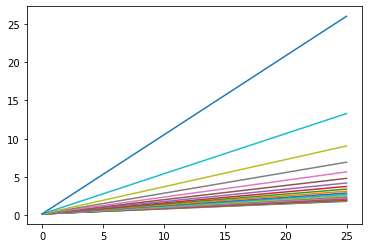

In [59]:
# plot c_policy_r for each j
for j in range(og.N - og.J_r + 1):
    plt.plot(og.a_grid, c_policy_r[j, :])

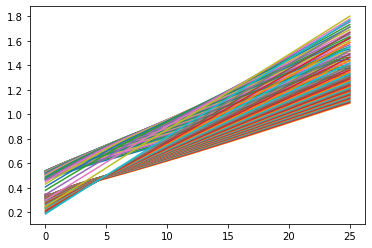

In [60]:
# plot c_policy_w for each j
for j in range(og.J_r - 1):
    for z_index, z in enumerate(og.z_grid):
        plt.plot(og.a_grid, c_policy_w[j, z_index, :])

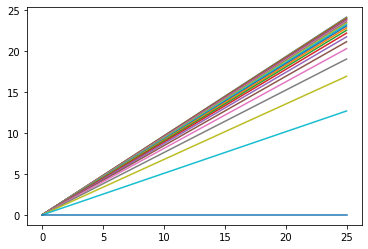

In [61]:
# plot a_policy_r for each j
for j in range(og.N - og.J_r + 1):
    plt.plot(og.a_grid, a_policy_r[j, :])

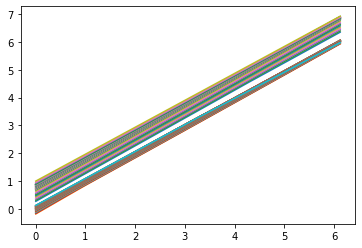

In [62]:
# plot a_policy_w for each j
for j in range(og.J_r - 1):
    for z_index, z in enumerate(og.z_grid):
        plt.plot(og.a_grid[0:50], a_policy_w[j, z_index, 0:50])

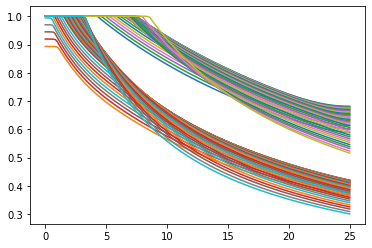

In [63]:
# plot l_policy for each j
for j in range(og.J_r - 1):
    for z_index, z in enumerate(og.z_grid):
        plt.plot(og.a_grid, l_policy[j, z_index, :])

In [96]:
import numpy as np
from numba import njit, float64, int64
from numba.experimental import jitclass

@njit
def nonuniform_grid(a, b, n=100, density=2):
    '''
    a: lower bound
    b: upper bound
    density: positive scalar for the density of the grid. > 1 for more points at the lower end
    '''
    linear_points = np.linspace(0, 1, n)
    nonlinear_points = (linear_points ** density) * (b-a) + a
    return nonlinear_points 


primitives = [
    ('beta', float64),
    ('gamma', float64),
    ('psi', float64),
    ('sigma', float64),
    ('alpha', float64),
    ('delta', float64),
    ('N', int64),
    ('J_r', int64),
    ('n', float64),
    ('a_min', float64),
    ('a_max', float64),
    ('na', int64),
    ('a_grid', float64[:]),
    ('z_grid', float64[:]),
    ('nz', int64),
    ('initial_dist', float64[:]),
    ('pi', float64[:,:]),
    ('theta', float64),
    ('eta', float64[:]),
    ('mu', float64[:])
]

@jitclass(primitives)
class OLGModel:
    def __init__(self, 
                 beta=0.97, 
                 gamma=2.50,
                 psi=2.0,
                 sigma=2.0, 
                 alpha=0.36, 
                 delta=0.06,
                 N=66, 
                 J_r=46, 
                 n=0.011,
                 a_min=0.00001,
                 a_max=35.0, 
                 na=1000, 
                 z_grid=np.array([2.0, 0.3]), 
                 initial_dist=np.array([0.2037, 0.7963]),
                 pi=np.array([[0.9261, 0.0739], [0.0189, 0.9811]]),
                 theta=0.11, 
                 eta=np.ones(45)):
        # Primitives
        self.beta = beta                                # discount rate
        self.gamma = gamma                              # Frisch elasticity
        self.psi = psi                                  # disutility of labor
        self.sigma = sigma                              # CRRA consumption
        self.alpha = alpha                              # capital share
        self.delta = delta                              # depreciation rate
        self.N = N                                      # death age
        self.J_r = J_r                                  # age of retirement
        self.n = n                                      # population growth rate
        self.a_min = a_min                              # assets lower bound
        self.a_max = a_max                              # assets upper bound
        self.na = na                                    # number of asset grid points
        self.a_grid = nonuniform_grid(a_min, a_max, na)
        self.z_grid = z_grid                            # productivity shocks
        self.nz = len(z_grid)                           # number of productivity shocks
        self.initial_dist = initial_dist                # initial distribution of productivity
        self.pi = pi                                    # Stochastic process for employment
        self.theta = theta                              # social security tax rate
        self.eta = eta                                  # age-efficiency profile - replace with values 'ef'
        mu = np.ones(N)
        for i in range(1, N):
            mu[i] = mu[i - 1] / (1 + n)
        mu /= np.sum(mu)
        self.mu = mu                                    # age proportions
    def u(self, c):
        return (c**(1-self.sigma)) / (1-self.sigma)
    def v(self, l):
        return self.psi * (l**(1+self.gamma)) / (1+self.gamma)
    def mu_c(self, c):
        return c**(-self.sigma)
    def inv_mu_c(self, value):
        # inverse marginal utility of consumption
        return value ** (-1/self.sigma)
    def l_from_c(self, c, coef):
        # from FOC, coef = w * z * eta * (1 - theta)
        return (coef * c ** (-self.sigma) / self.psi) ** (1/self.gamma)

def HH_egm(OLG, r=.05, w=1.05, b=.2):
    # solve household problem using endogenous grid method
    c_funcs = [None] * OLG.N
    a_grid = OLG.a_grid

    '''
    # find the upper bounds for assets at each working age
    a_upper = 0.0
    for j in range(OLG.J_r - 1):
        period_income = w * OLG.z_grid[0] * OLG.eta[j] * (1 - OLG.theta)
        a_upper = period_income + a_upper * (1 + r)                     # maximum assets assuming maximum income and savings
        a_grids[j, :] = nonuniform_grid(OLG.a_min, a_upper, OLG.na)
    
    for j in range(OLG.J_r - 1, OLG.N):
        a_grids[j, :] = nonuniform_grid(OLG.a_min, a_upper, OLG.na)
    '''


    # start at the end of life                      
    c_r = a_grid * (1 + r) + b           # retired consumption policy
    c_funcs[-1] = Interpolator(a_grid, c_r) 
    
    # iterate backward with Euler equation
    for j in range(OLG.N - 2, OLG.J_r - 2, -1):
        c_next = c_funcs[j+1].eval(a_grid)
        c_r = OLG.inv_mu_c(OLG.beta * (1+r) * OLG.mu_c(c_next))
        # find asset holdings from BC
        new_grid = (a_grid + c_r - b) / (1 + r)
        c_funcs[j] = Interpolator(new_grid, c_r)

    # start just before retirement
    c_funcs[OLG.J_r - 2] = []
    # find c with Euler equation, find l with FOC
    for z_index, z in enumerate(OLG.z_grid):
        coef = w * z * OLG.eta[-1] * (1 - OLG.theta)
        c_next = c_funcs[OLG.J_r - 1].eval(a_grid)
        c_w = OLG.inv_mu_c(OLG.beta * (1 + r) * OLG.mu_c(c_next))
        l_w = OLG.l_from_c(c_w, coef)
        l_w = np.clip(l_w, 0, 1) # enforce bounds
        # find asset holdings from BC
        new_grid = (a_grid + c_w - coef * l_w) / (1 + r)
        c_funcs[OLG.J_r - 2].append(Interpolator(new_grid, c_w))

    # iterate backwards with Euler equation for workers
    for j in range(OLG.J_r - 3, -1, -1):
        c_funcs[j] = []
        for z_index, z in enumerate(OLG.z_grid):
            coef = w * z * OLG.eta[j] * (1 - OLG.theta)
            # find the expected marginal utility of consumption in the next period
            E_mu_c = np.zeros(OLG.na)
            for zp_index in range(OLG.nz):
                mu_c_zp = OLG.mu_c(c_funcs[j+1][zp_index].eval(a_grid))
                E_mu_c += OLG.pi[z_index, zp_index] * mu_c_zp
            c_w = OLG.inv_mu_c(OLG.beta * (1 + r) * E_mu_c)
            l_w = OLG.l_from_c(c_w, coef)
            l_w = np.clip(l_w, 0, 1) # enforce bounds
            new_grid = (a_grid + c_w - coef * l_w) / (1 + r)
            c_funcs[j].append(Interpolator(new_grid, c_w))
    
    # get policy functions on grid using c_funcs
    a_policy_w = np.empty((OLG.J_r-1, OLG.nz, OLG.na)) # savings policy function for workers
    a_policy_r = np.empty((OLG.N-OLG.J_r + 1, OLG.na))         # savings policy function for retirees
    c_policy_w = np.empty((OLG.J_r-1, OLG.nz, OLG.na)) # consumption policy function for workers
    c_policy_r = np.empty((OLG.N-OLG.J_r + 1, OLG.na))         # consumption policy function for retirees
    l_policy = np.empty((OLG.J_r-1, OLG.nz, OLG.na))   # labor policy function for workers

    for j in range(OLG.J_r - 1):
        for z_index, z in enumerate(OLG.z_grid):
            coef = w * z * OLG.eta[j] * (1 - OLG.theta)
            c_policy_w[j, z_index, :] = c_funcs[j][z_index].eval(a_grid)
            l_policy[j, z_index, :] = np.clip(OLG.l_from_c(c_policy_w[j, z_index, :], coef), 0, 1)
            a_policy_w[j, z_index, :] = (1+r) * a_grid + coef*l_policy[j, z_index, :] - c_policy_w[j, z_index, :]

    for j in range(OLG.N - OLG.J_r + 1):
        c_policy_r[j, :] = c_funcs[j + OLG.J_r - 1].eval(a_grid)
        a_policy_r[j, :] = (1+r) * a_grid + b - c_policy_r[j, :]

    return a_policy_w, a_policy_r, c_policy_w, c_policy_r, l_policy

@njit
def steady_dist_egm(OLG, a_policy_w, a_policy_r):
    # Initialize distributions
    h_r = np.zeros((OLG.N - OLG.J_r + 1, OLG.na))
    h_w = np.zeros((OLG.J_r - 1, OLG.na, OLG.nz))

    # Initial distribution for workers
    h_w[0, 0, :] = OLG.initial_dist * OLG.mu[0]

    # Iterate forward for workers
    for j in range(1, OLG.J_r - 1):
        for a_k in range(OLG.na):
            for z in range(OLG.nz):
                for z_next in range(OLG.nz):
                    a_next = a_policy_w[j-1, z, a_k]
                    
                    # Find the position of a_next in the grid
                    if a_next <= OLG.a_grid[0]:
                        h_w[j, 0, z_next] += h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)
                    elif a_next >= OLG.a_grid[-1]:
                        h_w[j, -1, z_next] += h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)
                    else:
                        # Find the two nearest grid points
                        idx = np.searchsorted(OLG.a_grid, a_next)
                        # Split the probability between the two nearest grid points
                        weight_high = (a_next - OLG.a_grid[idx-1]) / (OLG.a_grid[idx] - OLG.a_grid[idx-1])
                        weight_low = 1 - weight_high
                        h_w[j, idx-1, z_next] += weight_low * h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)
                        h_w[j, idx, z_next] += weight_high * h_w[j-1, a_k, z] * OLG.pi[z, z_next] / (1 + OLG.n)

    # Transition from workers to retirees
    for a_k in range(OLG.na):
        for z in range(OLG.nz):
            a_next = a_policy_w[OLG.J_r-2, z, a_k]
            
            if a_next <= OLG.a_grid[0]:
                h_r[0, 0] += h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)
            elif a_next >= OLG.a_grid[-1]:
                h_r[0, -1] += h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)
            else:
                idx = np.searchsorted(OLG.a_grid, a_next)
                weight_high = (a_next - OLG.a_grid[idx-1]) / (OLG.a_grid[idx] - OLG.a_grid[idx-1])
                weight_low = 1 - weight_high
                h_r[0, idx-1] += weight_low * h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)
                h_r[0, idx] += weight_high * h_w[OLG.J_r-2, a_k, z] / (1 + OLG.n)

    # Iterate forward for retirees
    for j in range(1, OLG.N - OLG.J_r + 1):
        for a_k in range(OLG.na):
            a_next = a_policy_r[j-1, a_k]
            
            if a_next <= OLG.a_grid[0]:
                h_r[j, 0] += h_r[j-1, a_k] / (1 + OLG.n)
            elif a_next >= OLG.a_grid[-1]:
                h_r[j, -1] += h_r[j-1, a_k] / (1 + OLG.n)
            else:
                idx = np.searchsorted(OLG.a_grid, a_next)
                weight_high = (a_next - OLG.a_grid[idx-1]) / (OLG.a_grid[idx] - OLG.a_grid[idx-1])
                weight_low = 1 - weight_high
                h_r[j, idx-1] += weight_low * h_r[j-1, a_k] / (1 + OLG.n)
                h_r[j, idx] += weight_high * h_r[j-1, a_k] / (1 + OLG.n)

    # Normalize the distributions
    total_mass = np.sum(h_w) + np.sum(h_r)
    h_w /= total_mass
    h_r /= total_mass

    return h_w, h_r

@njit
def markov_simulation(pi, initial_dist, T):
    """
    Simulate a Markov process.
    
    Parameters:
    - pi: transition matrix
    - initial_dist: initial distribution
    - T: number of periods to simulate
    
    Returns:
    - states: array of simulated states
    """
    states = np.zeros(T, dtype=np.int64)
    states[0] = np.searchsorted((np.cumsum(initial_dist) > np.random.rand()).astype(np.int64), 1)
    
    for t in range(1, T):
        states[t] = np.searchsorted((np.cumsum(pi[states[t-1]]) > np.random.rand()).astype(np.int64), 1)
    
    return states

@njit
def stochastic_simulation(OLG, a_policy_w, a_policy_r, M=10000):
    """
    Stochastic simulation method for estimating the distribution of agents.
    
    Parameters:
    - OLG: instance of OLGModel class
    - a_policy_w: asset policy function for workers (shape: [J_r-1, nz, na])
    - a_policy_r: asset policy function for retirees (shape: [N-J_r+1, na])
    - M: number of households to simulate (default: 10000)
    
    Returns:
    - h_w: distribution of working households (shape: [J_r-1, na, nz])
    - h_r: distribution of retired households (shape: [N-J_r+1, na])
    """
    
    # Initialize arrays to store asset holdings and productivity for each household
    asset_holdings = np.zeros((M, OLG.N))
    productivity = np.zeros((M, OLG.J_r - 1), dtype=np.int64)
    
    # Simulate productivity shocks for working years
    for m in range(M):
        productivity[m] = markov_simulation(OLG.pi, OLG.initial_dist, OLG.J_r - 1)
    
    # Simulate asset accumulation
    for m in range(M):
        for j in range(1, OLG.J_r):
            z = productivity[m, j-1]
            a = asset_holdings[m, j-1]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            asset_holdings[m, j] = a_policy_w[j-1, z, a_index]
        
        for j in range(OLG.J_r, OLG.N + 1):
            a = asset_holdings[m, j-1]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            asset_holdings[m, j] = a_policy_r[j-OLG.J_r, a_index]
    
    # Initialize distribution arrays
    h_w = np.zeros((OLG.J_r - 1, OLG.na, OLG.nz))
    h_r = np.zeros((OLG.N - OLG.J_r + 1, OLG.na))
    
    # Bin the data and weight by age group
    for j in range(OLG.J_r - 1):
        for m in range(M):
            z = productivity[m, j]
            a = asset_holdings[m, j]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            h_w[j, a_index, z] += OLG.mu[j]
    
    for j in range(OLG.J_r, OLG.N + 1):
        for m in range(M):
            a = asset_holdings[m, j]
            a_index = np.searchsorted(OLG.a_grid, a)
            if a_index == OLG.na:
                a_index = OLG.na - 1
            h_r[j-OLG.J_r, a_index] += OLG.mu[j]
    
    # Normalize distributions
    h_w /= M
    h_r /= M
    
    return h_w, h_r

@njit
def K_L(OLG, h_w, h_r, l_w):
    # compute capital and labor supply implied by household decisions
    K = 0.0
    L = 0.0
    for j in range(OLG.J_r - 1):  # workers
        for a_index, a in enumerate(OLG.a_grid):
            for z_index, z in enumerate(OLG.z_grid):
                K += h_w[j, a_index, z_index] * a
                L += h_w[j, a_index, z_index] * z * OLG.eta[j] * l_w[j, z_index, a_index]

    for j in range(OLG.N - OLG.J_r + 1):
        for a_index, a in enumerate(OLG.a_grid):
            K += h_r[j, a_index] * a

    return K, L

def market_clearing(OLG, tol=0.0001, max_iter=200, rho=.02, K0=3.32, L0=0.34):
    # solve for the steady state using initial guess of capital and labor

    K, L = K0, L0
    n = 0
    # need initial retired share, will actually be very close to this value
    mu_r = np.sum(OLG.mu[OLG.J_r - 1:])
    error = 100 * tol
    while error > tol:
        r = OLG.alpha * (L / K) ** (1 - OLG.alpha) - OLG.delta
        w = (1 - OLG.alpha) * (K / L) ** OLG.alpha
        b = OLG.theta * w * L / mu_r
        a_w, a_r, _, _, l_w = HH_egm(OLG, r, w, b)
        h_w, h_r = steady_dist_egm(OLG, a_w, a_r)
        K_new, L_new = K_L(OLG, h_w, h_r, l_w)
        K = (1-rho) * K + rho * K_new
        L = (1-rho) * L + rho * L_new
        # print(f"K = {K}, L = {L}")
        error = max(abs(K_new - K), abs(L_new - L))
        n += 1
        if n > max_iter:
            print("No convergence")
            print(f"K = {K}, L = {L}")
            break

    if n < max_iter:
        print(f"Converged in {n} iterations")
        return K, L, r, w, b

In [101]:
og = OLGModel(eta=ef, na=500, gamma=2.5, a_min=.000001, a_max=25.0, z_grid=np.array([1.0, .25]))

In [102]:
eqbm_egm = market_clearing(og, rho=.5, tol=.00001, K0=2.46, L0=.29)

Converged in 11 iterations


In [103]:
eqbm_egm

(2.492486801951846,
 0.28656782442719275,
 0.030174512499257358,
 1.3943297424779442,
 0.18015736322247514)

---


In [114]:
from scipy.interpolate import interp1d

In [1]:
import numpy as np

In [4]:
x = np.array([.1, 0.0, 1.0, 1.0, .5, .2, .1, 0.0])

# find the last index where x == 1
idx = np.where(x == 1)[0][-1]
idx

3

In [167]:
x = [.5, 0.1, 1.0, 1.0, .5, .2, 0.1, 1.0]

least = np.argmin(x)
x[:least] = x[least] * np.ones_like(x[:least])
x = np.maximum.accumulate(x)
x

array([0.1, 0.1, 1. , 1. , 1. , 1. , 1. , 1. ])

In [6]:
x = np.array([-1, 0, 1, 2, 3])
binding = x < 1
x[binding] = 1
x

array([1, 1, 1, 2, 3])

In [7]:
from quantecon.optimize.root_finding import brentq

In [2]:
import numpy as np

In [3]:
np.clip(1.5, 0, 1)

1.0

In [7]:
np.minimum(1.5, 1.1)

1.1

In [8]:
x = np.array([0, 1, 2, 3, 4, 5])
np.minimum(x, 1)

array([0, 1, 1, 1, 1, 1])

In [22]:
x = np.array([0.0, 1.5, 0.0, 3.3, 4.5, 5.0])
np.argmax(x > 0)

1

In [19]:
x[1:1] = 1
x

array([0. , 1.5, 2.1, 3.3, 4.5, 5. ])